In [262]:
import os
import sys
import time
import copy
import datetime
import argparse
import pickle
from skimage.data import imread
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim
from PIL import Image
from skimage import draw
from matplotlib import pyplot as plt
%matplotlib inline
#sys.path.append('/floyd/home/PyTorch-YOLOv3_lite')
sys.path.append('/Users/mike/Desktop/airbus_kaggle/src/PyTorch-YOLOv3_lite')

In [263]:
%load_ext autoreload
%autoreload 2
from models import *
from utils.utils import *
from utils.datasets import *
from utils.parse_config import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [268]:
args = ['--image_folder','/Users/mike/Desktop/airbus_kaggle/data/train',
        '--box_file','/Users/mike/Desktop/airbus_kaggle/data/box_data.pickle',
        '--model_config_path','/Users/mike/Desktop/airbus_kaggle/src/PyTorch-YOLOv3_lite/config/sholo.cfg',
        '--weights_path','/Users/mike/Desktop/airbus_kaggle/classifier_weights/6.weights',
        '--checkpoint_dir','/Users/mike/Desktop/airbus_kaggle/src/output',
        '--img_size','768',
        '--epochs','30',
        '--n_cpu','4',
        '--use_cuda','True']        
# args = ['--image_folder','/floyd/input/airbus/train',
#         '--box_file','/floyd/input/airbus/box_data.pickle',
#         '--model_config_path','/floyd/home/PyTorch-YOLOv3_lite/config/classifier.cfg',
#         '--weights_path','/floyd/input/weights/6.weights',
#         '--checkpoint_dir','/floyd/home/output',
#         '--img_size','64',
#         '--epochs','30',
#         '--n_cpu','4',
#         '--use_cuda','True']
parser = argparse.ArgumentParser()
parser.add_argument('--epochs', type=int, default=30, help='number of epochs')
parser.add_argument('--image_folder', type=str, default='data/samples', help='path to dataset')
parser.add_argument('--box_file', type=str, default='data/samples', help='path to box data')
parser.add_argument('--batch_size', type=int, default=16, help='size of each image batch')
parser.add_argument('--model_config_path', type=str, default='config/yolov3.cfg', help='path to model config file')
parser.add_argument('--weights_path', type=str, default='weights/yolov3.weights', help='path to weights file')
parser.add_argument('--conf_thres', type=float, default=0.8, help='object confidence threshold')
parser.add_argument('--nms_thres', type=float, default=0.4, help='iou thresshold for non-maximum suppression')
parser.add_argument('--n_cpu', type=int, default=0, help='number of cpu threads to use during batch generation')
parser.add_argument('--img_size', type=int, default=416, help='size of each image dimension')
parser.add_argument('--checkpoint_interval', type=int, default=1, help='interval between saving model weights')
parser.add_argument('--checkpoint_dir', type=str, default='checkpoints', help='directory where model checkpoints are saved')
parser.add_argument('--use_cuda', type=bool, default=True, help='whether to use cuda if available')
opt = parser.parse_args(args)

In [269]:
cuda = torch.cuda.is_available() and opt.use_cuda

os.makedirs(opt.checkpoint_dir, exist_ok=True)

# Get hyper parameters
hyperparams     = parse_model_config(opt.model_config_path)[0]
learning_rate   = float(hyperparams['learning_rate'])
momentum        = float(hyperparams['momentum'])
decay           = float(hyperparams['decay'])
burn_in         = int(hyperparams['burn_in'])

# Initiate model
model = Darknet(opt.model_config_path)
#model.load_weights(opt.weights_path)
model.apply(weights_init_normal)

if cuda:
    model = model.cuda()

model.train();



In [126]:
class BoxDetections(Dataset):
    def __init__(self,imgdir,imgsize,data):
        super().__init__()
        self.imgdir = imgdir
        self.imgsize = imgsize
        self.box_image_ids = data['box_image_ids']
        self.L1 = data['L1']
        self.L2 = data['L2']
        self.R0 = data['C0'] # accidently switched when saved
        self.C0 = data['R0'] # accidently switched when saved
        self.theta = data['theta']
        self.all_image_ids = data['all_image_ids']
        self.num_ships = data['num_ships']
        self.total_ships = sum(self.num_ships)
        self.total_imgs = len(self.all_image_ids)
        self.max_objects = 20
    def __len__(self):
        return self.total_imgs
    def __getitem__(self,idx):
        img_path = os.path.join(self.imgdir,self.all_image_ids[idx])
        img = np.array(Image.open(img_path)) 
        # Channels-first
        img = np.transpose(img, (2, 0, 1))
        # As pytorch tensor
        img = torch.from_numpy(img).float()
        # Find boxes in img
        # Fill matrix
        labels = np.zeros((self.max_objects, 7)) 
        if self.num_ships[idx] != 0:
            box_inds = [i for i,x in enumerate(self.box_image_ids) if x is self.all_image_ids[idx]]
            for i,ind in enumerate(box_inds[:self.max_objects]):
                L1 = self.L1[ind]
                L2 = self.L2[ind]
                R0 = self.R0[ind]
                C0 = self.C0[ind]
                theta = self.theta[ind]
                # Calculate ratios from coordinates
                labels[i, 1] = R0 
                labels[i, 2] = C0 
                labels[i, 3] = L1 
                labels[i, 4] = L2
                labels[i, 5] = theta
        labels = torch.from_numpy(labels)
        return img_path, img, labels
    

In [270]:
# Get dataloader
with open(opt.box_file, 'rb') as f:
    data = pickle.load(f)
    
dataloader = torch.utils.data.DataLoader(
    BoxDetections(opt.image_folder,opt.img_size,data),
    batch_size=opt.batch_size, shuffle=True, num_workers=opt.n_cpu, pin_memory=True)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, dampening=0, weight_decay=decay)


In [128]:
bdtest = BoxDetections(opt.image_folder,768,data)

In [129]:
img_path, img, label = bdtest.__getitem__(2)

In [130]:
label

tensor([[  0.0000, 746.5000, 149.0000,  36.0600,  10.8200,  -0.9828,   0.0000],
        [  0.0000, 760.0000, 129.0000,  10.3000,   5.8300,  -1.0637,   0.0000],
        [  0.0000, 717.0000, 101.0000,  10.0500,   3.0000,   1.4711,   0.0000],
        [  0.0000, 662.5000, 197.5000,   4.1200,   2.2400,   1.3258,   0.0000],
        [  0.0000, 633.0000, 183.5000,   7.2800,   3.1600,  -0.2783,   0.0000],
        [  0.0000, 710.5000, 116.0000,   7.2800,   3.1600,   1.2925,   0.0000],
        [  0.0000, 713.0000, 103.5000,  14.1400,   4.1200,   1.4289,   0.0000],
        [  0.0000, 708.0000, 104.5000,  12.1700,   4.1200,   1.4056,   0.0000],
        [  0.0000, 757.0000, 158.5000,  39.7000,  10.6300,  -0.8567,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  

In [160]:
def box2mask(box,mask_size=(768,768)):
    R0 = box[0]
    C0 = box[1]
    L1 = box[2]
    L2 = box[3]
    theta = box[4]
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    box = 0.5*np.array([[L1,L2],[L1,-L2],[-L1,-L2],[-L1,L2]]).T
    box_rot = np.dot(R,box)
    rr, cc = draw.polygon(R0+box_rot[0,:],C0+box_rot[1,:],shape=mask_size)
    mask = np.zeros(mask_size,dtype=int)
    mask[rr,cc] = 1
    return mask

def mask_iou(mask1,mask2):
    intersection = mask1 & mask2
    union = mask1 | mask2
    iou = np.sum(intersection) / np.sum(union)
    return iou

def obox_iou(box1,box2,imsize=(768,768)):
    mask_1 = box2mask(gt_box_1)
    mask_2 = box2mask(gt_box_2)
    return mask_iou(mask_1,mask_2)

In [161]:
gt_box_1 = label[0,1:].numpy()
#gt_box_2 = label[1,:].numpy()
gt_box_2 = copy.deepcopy(gt_box_1)
gt_box_2[1] += 0.5
print(obox_iou(mask_1,mask_2))

0.942652329749104


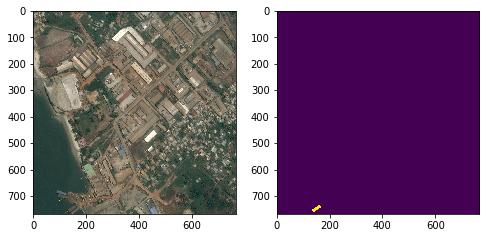

In [133]:
fig,ax = plt.subplots(1,2,figsize=(8,5))
ax[0].imshow(img.permute(1,2,0).numpy().astype(int))
ax[1].imshow(mask)

In [101]:
gt_box

array([ 0.00000000e+00,  7.46500000e+02,  1.49000000e+02,  3.60600000e+01,
        1.08200000e+01, -8.32050293e-01,  5.54700199e-01])

In [192]:
anchor_theta = torch.tensor(np.pi/4)
sin = 1000000
cos = 1
anchor_sin = torch.sin(anchor_theta)
anchor_cos = torch.cos(anchor_theta)
anchor_sin_logit = torch.log(0.5*(anchor_sin+1)/(1-0.5*(anchor_sin+1)))
anchor_cos_logit = torch.log(anchor_cos/(1-anchor_cos))
sin_test = -1 + 2*torch.sigmoid(sin * anchor_sin_logit)  # -1 to 1
cos_test = torch.sigmoid(cos * anchor_cos_logit)         # 0 to 1   
theta_test = torch.atan(sin_test/cos_test)
print(anchor_theta,theta_test)
print(anchor_sin,sin_test)
print(anchor_cos,cos_test)

tensor(0.7854) tensor(0.9553)
tensor(0.7071) tensor(1.)
tensor(0.7071) tensor(0.7071)


In [193]:
anchor_theta = torch.tensor(np.pi/4)
sin = 1000000
cos = 1
anchor_sin = torch.sin(anchor_theta)
anchor_cos = torch.cos(anchor_theta)
anchor_sin_logit = torch.log(0.5*(anchor_sin+1)/(1-0.5*(anchor_sin+1)))
anchor_cos_logit = torch.log(anchor_cos/(1-anchor_cos))
sin_test = -1 + 2*torch.sigmoid(sin * anchor_sin_logit)  # -1 to 1
cos_test = torch.sigmoid(cos * anchor_cos_logit)         # 0 to 1   
theta_test = torch.atan(sin_test/cos_test)
print(anchor_theta,theta_test)
print(anchor_sin,sin_test)
print(anchor_cos,cos_test)

tensor(0.7854) tensor(0.9553)
tensor(0.7071) tensor(1.)
tensor(0.7071) tensor(0.7071)


In [246]:
anchor_theta = torch.tensor(0.4)
network_pred_1 = torch.tensor(3.)
network_pred_2 = torch.tensor(3.)
#anchor_sin = torch.sin(anchor_theta)
#anchor_cos = torch.cos(anchor_theta)
delta_sin = -1 + 2*torch.sigmoid(network_pred_1)  # -1 to 1
delta_cos = torch.sigmoid(network_pred_2)         # 0 to 1  
pred_theta = anchor_theta + torch.atan(delta_sin/delta_cos)
delta_theta = pred_theta - anchor_theta
delta_sin_truth = torch.sin(delta_theta)
delta_cos_truth = torch.cos(delta_theta)
print(delta_sin,delta_sin_truth)
print(delta_cos,delta_cos_truth)
#print(delta_theta*180/np.pi)

tensor(0.9051) tensor(0.6888)
tensor(0.9526) tensor(0.7249)


-0.9987502603949663

In [257]:
(-np.pi/2+0.1) % np.pi/2

0.8353981633974483

In [261]:
gtheta = -np.pi/2
atheta = +np.pi/2-1
diffs = [gtheta-atheta-np.pi,gtheta-atheta,gtheta-atheta+np.pi]
print(diffs)


[-5.283185307179586, -2.141592653589793, 1.0]
